# <a href="https://miptstats.github.io/courses/ad_fivt.html">Введение в анализ данных</a>


## Компьютерное зрение & генеративные модели


<a href="https://miptstats.github.io/courses/ad_fivt/CV_classification.html" target="_blank">Ранее</a> мы рассмотрели задачу классификации с помощью сверточных нейронных сетей.

В этом ноутбуке приведены примеры обученных сетей для переноса стиля и генерации изображений по промпту. На лекции были рассказаны основные моменты работы этих методов. Это ознакомительный ноутбук, призванный продемонстрировать некоторые продвижения в компьютерном зрении за последние несколько лет.

Чтобы все корректно отработало, этот ноутбук, как и в прошлый раз, нужно запускать в той среде, где есть графический процессор GPU. Бесплатно воспользоваться GPU можно в <a href="https://colab.research.google.com/?hl=ru" target="_blank">Google Colab</a> и [Kaggle](https://www.kaggle.com/). Однако учтите, что на данный момент доступ к GPU ограничен работой в несколько часов в сутки. Для того, чтобы подключиться к GPU в Colab, зайдите в меню `Среда выполнения`, выберите опцию `Сменить среду выполнения`. В списке аппаратных ускорителей выберите GPU.

In [ ]:
import os
import seaborn as sns
from pathlib import Path
import matplotlib.pyplot as plt

sns.set(palette="Set2")

## 2. Нейросетевой перенос стиля

Рассмотрим задачу переноса стиля с одной картинки на другую и ее решение, основанное на свойствах сверточных нейронных сетей. Возьмем реализацию метода Neural Style Transfer, описанного в [статье](https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Gatys_Image_Style_Transfer_CVPR_2016_paper.pdf), из [репозитория](https://github.com/nazianafis/Neural-Style-Transfer). Склонируем репозиторий и заимпортируем необходимые файлы.

In [ ]:
!git clone https://github.com/nazianafis/Neural-Style-Transfer
# Перейдем в директорию скачанного репозитория
%cd /content/Neural-Style-Transfer/

# Небольшая обработка скрипта, не менять!
file_path = "NST.py"
with open(file_path, "r") as file:
    # Убираем автоматический запуск
    lines = file.readlines()[:183]
# Вывод логов только каждые 100 эпох
lines = lines[:175] + ["            if cnt % 100 == 0:\n"] + lines[175:]
lines[176] = "    " + lines[176]
with open(file_path, "w") as file:
    file.writelines(lines)

from NST import *

Cloning into 'Neural-Style-Transfer'...
remote: Enumerating objects: 379, done.
remote: Counting objects: 100% (154/154), done.
remote: Compressing objects: 100% (119/119), done.
remote: Total 379 (delta 72), reused 105 (delta 34), pack-reused 225
Receiving objects: 100% (379/379), 92.21 MiB | 14.34 MiB/s, done.
Resolving deltas: 100% (143/143), done.
/content/Neural-Style-Transfer


Как работает метод мы разбирали на [лекции](https://miptstats.github.io/courses/ad_fivt/lecture5_2.pdf).

**Идея.** Хотим оптимизировать картинку $\overrightarrow{x}$ так, чтобы:
* Content Features $\overrightarrow{x}$ были близки к Content Features картинки контента;
* Style Features $\overrightarrow{x}$ были близки к Style Features картинки стиля.

**В данной реализации:**
1. Инициализируем $\overrightarrow{x}$ картинкой контента и постепенно добавляем в нее нужный стиль.
2. Задаем лосс близости контента и лосс близости стиля. Они используют предобученную сверточную нейросеть VGG19 как экстрактор признаков, ее веса не изменяются.
3. Оптимизируем $\overrightarrow{x}$ с помощью L-BFGS &mdash; метода оптимизации (ускорение градиентного спуска), подробнее о нем будет на методах оптимизации на 3 курсе.

**Выделение признаков:**
* **Сontent features.** Выходы глубоких слоев
сверточной нейросети хранят высокоуровневую информацию
про изображенные объекты.

* **Style features** &mdash; матрицы Грама
по выходам слоев CNN, где
начальные слои представляют мелкие текстуры, а более глубокие &mdash; особенности
стиля художника.

> **Q:** Зачем матрица Грама, разве выделение локальных зависимостей &mdash; не задача свертки?

> **A:** Выход сверточного слоя &mdash; признаковое представление картинки, отражающее степень содержания паттернов, описываемых ядрами сверток. Для выделения стиля полезно смотреть на корреляцию (степень зависимости) этих признаков. В некотором смысле стиль &mdash; совокупность паттернов и их взаимодействие. А матрица Грама как раз выражает корреляцию каждого признака с каждым, но, как вы правильно заметили, сильно увеличивает масштабы вычислений.




Напишем функцию для запуска метода для заданной картинки контента и стиля, а также функцию визуализации результатов.

In [ ]:
def run_neural_style_transfer(content_image="c1.jpg", style_image="s1.jpg"):
    """
    Функция для запуска метода Neural Style Transfer.

    :param content_image: имя файла картинки контента
    :param style_image: имя файла картинки стиля
    :return: results_path -- путь к папке, в которую сохранился результат
    """
    PATH = ""
    default_resource_dir = os.path.join(PATH, "data")
    content_images_dir = os.path.join(default_resource_dir, "content-images")
    style_images_dir = os.path.join(default_resource_dir, "style-images")
    output_img_dir = os.path.join(default_resource_dir, "output-images")
    img_format = (4, ".jpg")

    # Задаем конфиги, включая вес компонент лосса
    optimization_config = {
        "content_img_name": content_image,
        "style_img_name": style_image,
        "height": 400,
        "content_weight": 100000.0,
        "style_weight": 30000.0,
        "tv_weight": 1.0,
    }
    optimization_config["content_images_dir"] = content_images_dir
    optimization_config["style_images_dir"] = style_images_dir
    optimization_config["output_img_dir"] = output_img_dir
    optimization_config["img_format"] = img_format

    results_path = neural_style_transfer(optimization_config)
    return results_path

In [ ]:
def visualize_style_transfer(content_image, style_image, results_path):
    """
    Визуализация результатов.

    :param content_image: имя файла картинки контента
    :param style_image: имя файла картинки стиля
    :param results_path: путь к папке, в которую сохранился результат
    """
    if len(os.listdir(results_path)) == 0:
        return
    plt.figure(figsize=(13, 3))
    folders = [
        "content-images/",
        "output-images/" + Path(results_path).name + "/",
        "style-images/",
    ]
    combined_image = (
        Path(content_image).stem + "_" + Path(style_image).stem + ".jpg"
    )
    files = [content_image, combined_image, style_image]
    titles = ["Контент", "Результат", "Стиль"]
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.imshow(plt.imread("data/" + folders[i] + files[i]))
        plt.title(titles[i])
        plt.xticks([])
        plt.yticks([])

Запустим Neural Style Transfer на парах контент-стиль, доступных в репозитории. Картинки-примеры лежат в `data/content-images` и `data/style-images` соответственно. Результаты сохраняются в `data/output-images/combined_<content_img>_<style_img>/<content_img>_<style_img>.jpg`.

In [ ]:
content_images = sorted(os.listdir("data/content-images"))
style_images = sorted(os.listdir("data/style-images"))

result_paths = []
for content_image, style_image in zip(content_images, style_images):
    results_path = run_neural_style_transfer(content_image, style_image)
    result_paths.append(results_path)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Using VGG19 in the optimization procedure.
L-BFGS | iteration: 000, total loss=3446674817024.0000, content_loss=      0.0000, style loss=3446667600000.0000, tv loss=7292746.0000
L-BFGS | iteration: 100, total loss=36545269760.0000, content_loss=1636035644.5312, style loss=34891616250.0000, tv loss=17615628.0000
L-BFGS | iteration: 200, total loss=11921997824.0000, content_loss=1652365625.0000, style loss=10250455312.5000, tv loss=19177282.0000
L-BFGS | iteration: 300, total loss=7036205568.0000, content_loss=1648760351.5625, style loss=5368206562.5000, tv loss=19238864.0000
L-BFGS | iteration: 400, total loss=5205744128.0000, content_loss=1640404687.5000, style loss=3546391171.8750, tv loss=18947876.0000
L-BFGS | iteration: 500, total loss=4413362176.0000, content_loss=1627640234.3750, style loss=2767006406.2500, tv loss=18715636.0000
L-BFGS | iteration: 600, total loss=3994198528.0000, content_loss=1615958691.4062, style loss=2359643203.1250, tv loss=18596980.0000
L-BFGS | iteration: 

> Пояснение логов: на каждой 100-ой итерации выводится лосс: total loss; его составляющие content loss, style loss; и tv loss (total variation) – некоторая регуляризация для улучшения структуры картинки.

Выведем полученные картинки:

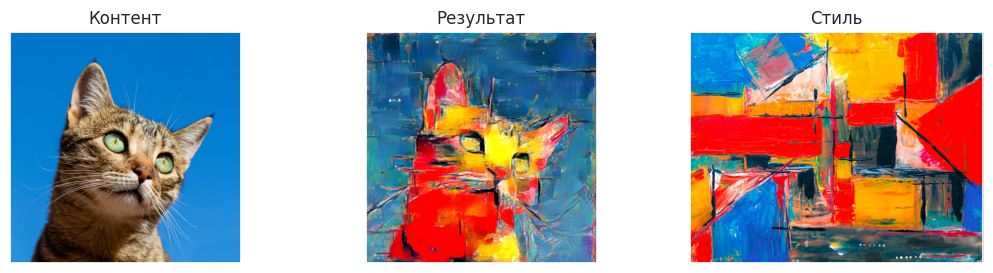

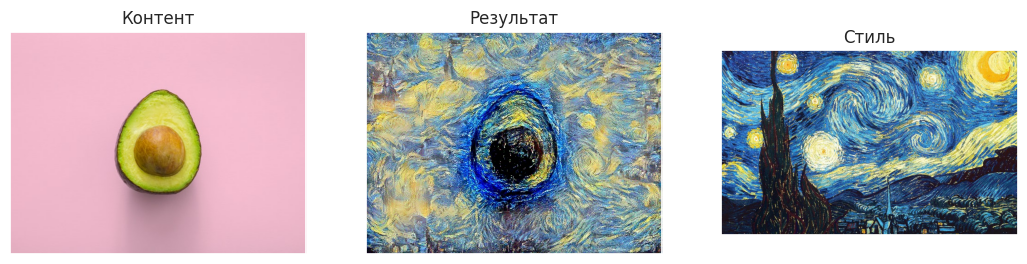

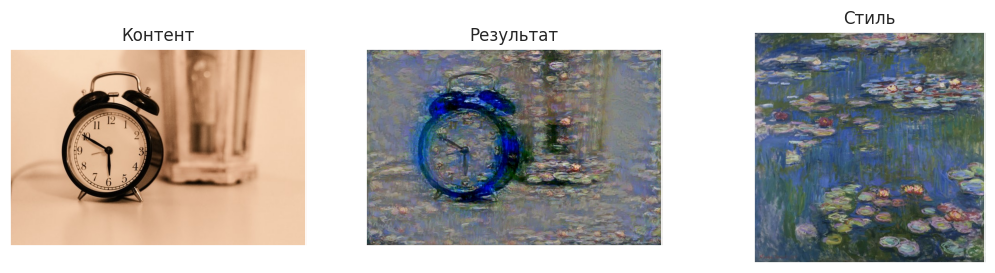

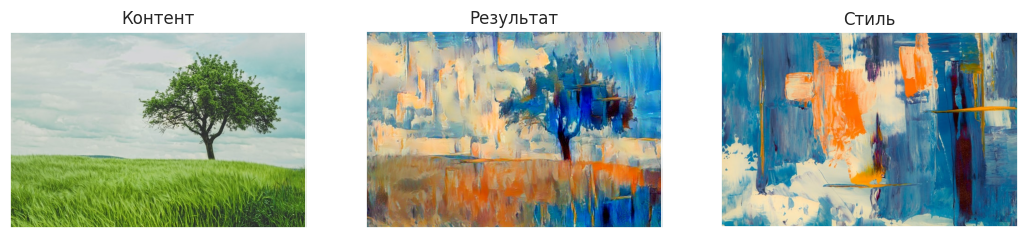

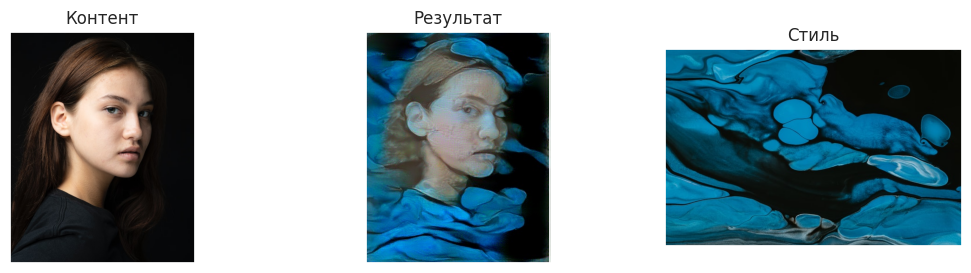

In [ ]:
for content_image, style_image, results_path in zip(
    content_images, style_images, result_paths
):
    visualize_style_transfer(content_image, style_image, results_path)

Мы успешно перенесли стиль с правой картинки на контент левой и получили необычные результаты.

Попробуем применить перенос стиля на своих картинках. Для этого можно подключить Google Диск к файлам среды Google Colab. Загрузите файлы на диск, обновите меню файлов слева, и увидите их в `content/drive`.

In [ ]:
# подключим Google Drive
from google.colab import drive

drive.mount("/content/drive")

# пути к нужным папкам в Drive
content_path = "/content/drive/MyDrive/DS/style_transfer_images/content"
style_path = "/content/drive/MyDrive/DS/style_transfer_images/style"

# очистим предыдущие картинки, скопируем новые
!rm -r data/content-images
!mkdir data/content-images
!cp -a /$content_path/. data/content-images/

!rm -r data/style-images
!mkdir data/style-images
!cp -a /$style_path/. data/style-images/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Запустим и посмотрим, что получится:

In [ ]:
content_images = sorted(os.listdir("data/content-images"))
style_images = sorted(os.listdir("data/style-images"))
result_paths = []
for content_image, style_image in zip(content_images, style_images):
    results_path = run_neural_style_transfer(content_image, style_image)
    result_paths.append(results_path)

Using VGG19 in the optimization procedure.
L-BFGS | iteration: 000, total loss=951764320256.0000, content_loss=      0.0000, style loss=951746580000.0000, tv loss=17784880.0000
L-BFGS | iteration: 100, total loss=3000761088.0000, content_loss=1021630273.4375, style loss=1939623750.0000, tv loss=39506920.0000
L-BFGS | iteration: 200, total loss=1648944896.0000, content_loss=925682128.9062, style loss=682582675.7812, tv loss=40680200.0000
L-BFGS | iteration: 300, total loss=1358226688.0000, content_loss=863602539.0625, style loss=453543896.4844, tv loss=41080144.0000
L-BFGS | iteration: 400, total loss=1244255872.0000, content_loss=828277636.7188, style loss=374861865.2344, tv loss=41116412.0000
L-BFGS | iteration: 500, total loss=1182209920.0000, content_loss=804843310.5469, style loss=336351298.8281, tv loss=41015240.0000
L-BFGS | iteration: 600, total loss=1143759104.0000, content_loss=788581005.8594, style loss=314325322.2656, tv loss=40852712.0000
L-BFGS | iteration: 700, total loss

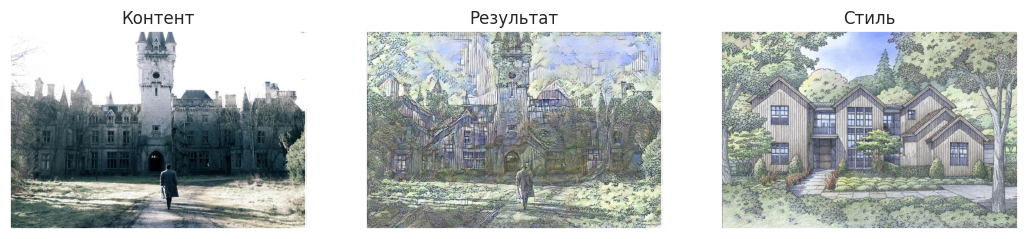

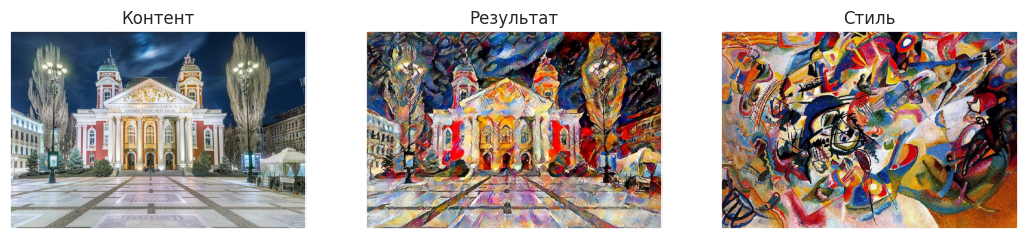

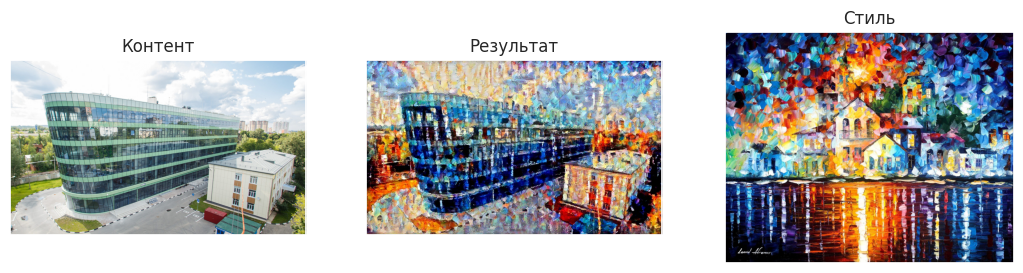

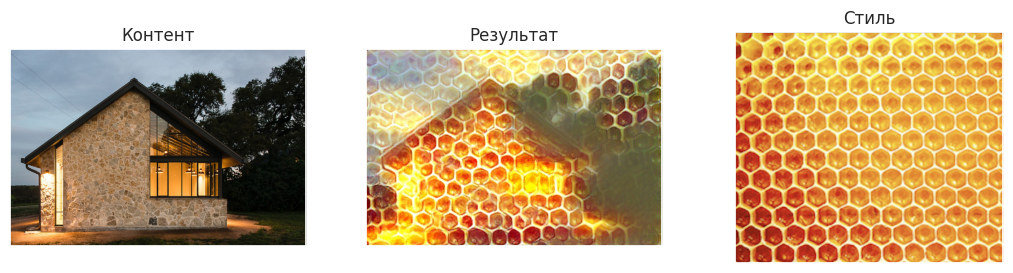

In [ ]:
# Сохраним результаты
!cp -r data/output-images /content/drive/MyDrive/DS

# Визуализируем
for content_image, style_image, results_path in zip(
    content_images, style_images, result_paths
):
    visualize_style_transfer(content_image, style_image, results_path)

## 3. Диффузионные модели

За последние несколько лет выложено множество разных диффузионных моделей, обладающих State-of-the-Art способностями генерации изображений: [Stable Diffusion](https://huggingface.co/CompVis/stable-diffusion), [SDXL](https://stablediffusionxl.com/), [Kandisnky](https://huggingface.co/docs/diffusers/en/using-diffusers/kandinsky), [YandexART](https://ya.ru/ai/art), [Fooocus](https://fooocus.pro/), [ControlNet](https://huggingface.co/docs/diffusers/en/using-diffusers/controlnet). В этом ноутбуке мы опробуем [SDXL Turbo](https://stability.ai/news/stability-ai-sdxl-turbo): A Real-Time Text-to-Image Generation Model, вышедшую в 2023 году. SDXL Turbo основан на новой технологии дистилляции, которая позволяет модели синтезировать выходные данные изображения за один шаг и генерировать выходные данные преобразования текста в изображение в реальном времени, сохраняя при этом высокую точность выборки.

Сначала установим библиотеку `diffusers`, в которой реализовано большинство из этих моделей.

In [ ]:
!pip install -q diffusers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 14.1 MB/s eta 0:00:00


Создадим pipeline с нужной моделью и перенесем на CUDA.

In [ ]:
from diffusers import AutoPipelineForText2Image
import torch

pipe = AutoPipelineForText2Image.from_pretrained(
    "stabilityai/sdxl-turbo", torch_dtype=torch.float16, variant="fp16"
).to("cuda")

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/685 [00:00<?, ?B/s]

Fetching 18 files:   0%|          | 0/18 [00:00<?, ?it/s]

scheduler/scheduler_config.json:   0%|          | 0.00/459 [00:00<?, ?B/s]

text_encoder_2/config.json:   0%|          | 0.00/575 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/565 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/704 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/586 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer_2/special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer_2/tokenizer_config.json:   0%|          | 0.00/855 [00:00<?, ?B/s]

tokenizer_2/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/1.78k [00:00<?, ?B/s]

tokenizer_2/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/607 [00:00<?, ?B/s]

model.fp16.safetensors:   0%|          | 0.00/246M [00:00<?, ?B/s]

model.fp16.safetensors:   0%|          | 0.00/1.39G [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/5.14G [00:00<?, ?B/s]

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Теперь этот `pipe` можно переиспользовать для генерации нескольких изображений. Большую роль в качестве сгенерированных картинок играет промпт (текстовый запрос). Часто указывают "artstation" и высокую детализированность в дополнение к основному запросу. Также можно поэкспериментировать с разными стилями.

  0%|          | 0/1 [00:00<?, ?it/s]

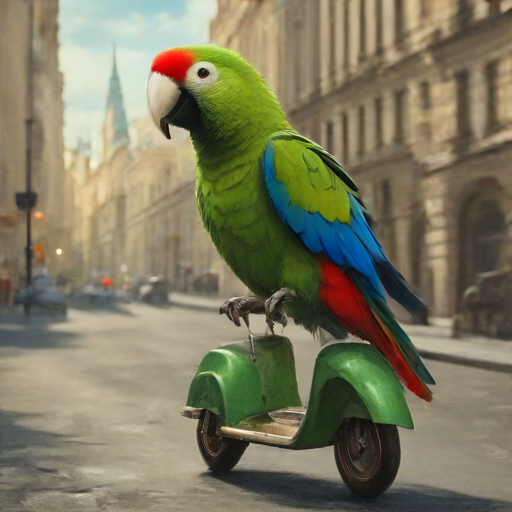

In [ ]:
prompt = "a photo of a parrot riding a scooter in Moscow, artstation, highly detailed"

# Передаем prompt в pipe, указываем параметры
# Модель проводит генерацию картинки, соответствующей запросу
image = pipe(prompt=prompt, num_inference_steps=1, guidance_scale=0.0).images[0]
image

  0%|          | 0/1 [00:00<?, ?it/s]

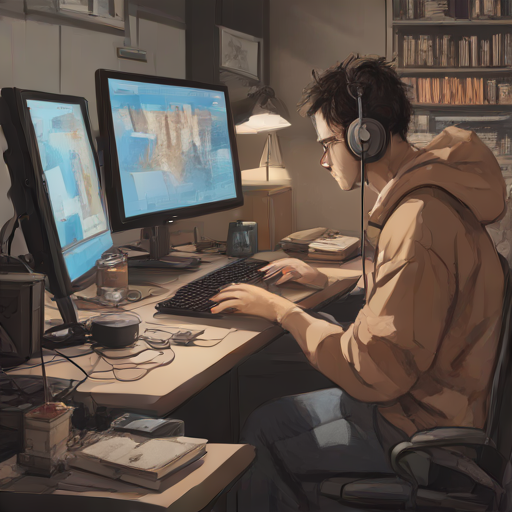

In [ ]:
prompt = "computer science student pulling an all-nighter, artstation, extremely detailed"
image = pipe(prompt=prompt, num_inference_steps=1, guidance_scale=0.0).images[0]
image

Можно генерировать картинки в стиле рисунков:

  0%|          | 0/1 [00:00<?, ?it/s]

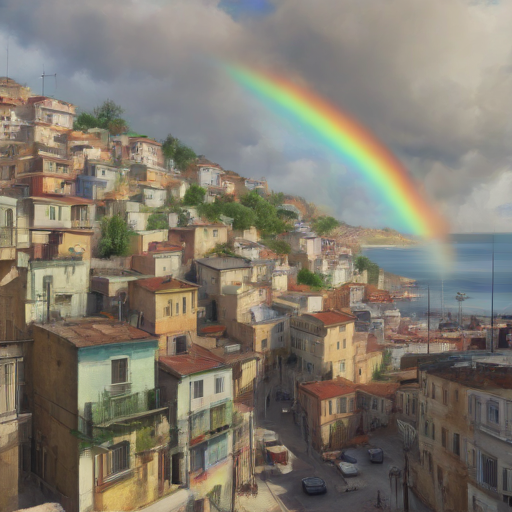

In [ ]:
prompt = "Valparaiso city view on a sunny day with a rainbow, painting, artstation, extremely detailed"
image = pipe(prompt=prompt, num_inference_steps=1, guidance_scale=0.0).images[0]
image

  0%|          | 0/1 [00:00<?, ?it/s]

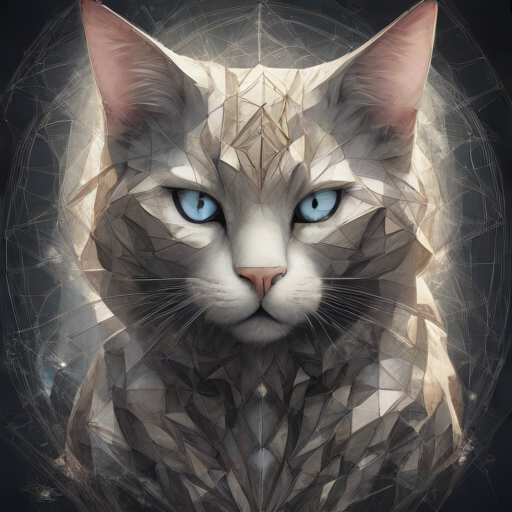

In [ ]:
prompt = "cat as the ultimate autonomous entity with sacred geometry, artstation, highly detailed"
image = pipe(prompt=prompt, num_inference_steps=1, guidance_scale=0.0).images[0]
image

**Выводы:** мы применили Neural Style Transfer на собственных и данных картинках, перенося стиль с картинки стиля на картинку контента. Также научились запускать одну из диффузионных моделей на произвольных промптах.